In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import date
from datetime import datetime
import re
from sklearn.impute import SimpleImputer

%matplotlib inline

# Upload Datasets and Describe

1. Health Systems Dataset

In [2]:
health_sys = pd.read_csv('data/2.12_Health_systems.csv')
health_sys.head()

,Country_Region,Province_State,World_Bank_Name,Health_exp_pct_GDP_2016,Health_exp_public_pct_2016,Health_exp_out_of_pocket_pct_2016,Health_exp_per_capita_USD_2016,per_capita_exp_PPP_2016,External_health_exp_pct_2016,Physicians_per_1000_2009-18,Nurse_midwife_per_1000_2009-18,Specialist_surgical_per_1000_2008-18,Completeness_of_birth_reg_2009-18,Completeness_of_death_reg_2008-16
0,Afghanistan,NaN,Afghanistan,10.2,5.1,77.4,57.2,162.8,17.5,0.3,0.3,0.0,42.3,NaN
1,Albania,NaN,Albania,6.7,41.4,58.0,271.5,759.7,0.7,1.2,3.6,11.6,98.4,53.0
2,Algeria,NaN,Algeria,6.6,67.7,30.9,260.4,998.2,0.0,1.8,2.2,12.1,100.0,NaN
3,Andorra,NaN,Andorra,10.4,49.1,41.7,3834.7,4978.7,NaN,3.3,4.0,83.1,100.0,80.0
4,Angola,NaN,Angola,2.9,44.1,35.2,95.2,185.8,3.6,0.2,1.3,NaN,25.0,NaN


In [3]:
# Change column names to make it easier to use for analysis
health_sys.columns = ['Country_Region', 'Province_State', 'World_Bank_Name',
       'h_exp_pct_GDP', 'h_exp_pub_pct',
       'h_exp_oop_pct', 'h_exp_pcapita_usd',
       'pcapita_exp_ppp', 'h_ext_exp_pct',
       'physicians_per_1k', 'nurse_per_1k','specialist_per_1k',
       'birth_reg_pct','death_reg_pct']

#health_sys.columns

In [4]:
# Remove Province_State that are not null and remove Country_Region that is null (will be using to join)
# health_sys[(health_sys['Province_State'].isna()) & (health_sys['Country_Region'].notnull())].duplicated().sum()
health_sys2 = health_sys[(health_sys['Province_State'].isna()) & (health_sys['Country_Region'].notnull())].copy()
health_sys2.drop(['Province_State','World_Bank_Name'], axis=1, inplace=True)

In [5]:
# Fix Names so that they match Covid Dataset
health_sys2['Country_Region'] = (health_sys2['Country_Region']
                                 .map(lambda x: 'United States' if x == 'US' else
                                      'Russian Federation' if x == 'Russia' else x)
                                )


2. Covid Dataset

In [6]:
covid = pd.read_csv('data/covid_19_data.csv')
covid.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [146]:
# print(covid.shape)
# print(covid.describe(include='all'))
# print(covid.info())
# print(covid.dtypes)

This is a cumulative dataset so we want to get the last observation for every Country's Province/State. There are 3 countries that track city covid cases in addition to the overall State's cases. We will remove these cities/counties so that we don't include duplicate counts that are already included in the State counts.

In [7]:
# Find countries that have cities in them
#covid['Province/State'].unique()
print('Countries with cities and states:')
print(covid[covid['Province/State'].str.contains(',',na=False)]['Country/Region'].unique())

# You can see the countries already include covid counts for the Provinces/States that these cities are in
print('\nCities and States in Canada:')
print(covid[covid['Country/Region'] == 'Canada']['Province/State'].unique())

# Filter out cities from data frame and see difference in data frame shape
covid2 = covid[~covid['Province/State'].str.contains(',',na=False)].copy().reset_index(drop=True)
print('\n %d records were dropped' % (covid.shape[0] - covid2.shape[0]))

Countries with cities and states:
['US' 'Canada' 'Netherlands']

Cities and States in Canada:
['Ontario' 'British Columbia' 'Toronto, ON' 'London, ON' ' Montreal, QC'
 'Calgary, Alberta' 'Edmonton, Alberta' 'Alberta' 'Quebec' 'New Brunswick'
 'Manitoba' 'Saskatchewan' 'Grand Princess' 'Newfoundland and Labrador'
 'Prince Edward Island' 'Nova Scotia' 'Northwest Territories'
 'Diamond Princess cruise ship' 'Recovered' 'Yukon']

 1024 records were dropped


In [8]:
# Impute missing value in Province/State so that they don't get discarded in the group by
covid2.isna().any()
covid2['Province/State'] = covid2['Province/State'].fillna('MISS')

# Look at any country names and see if they need cleaning
# covid2['Country/Region'].unique()
# covid2['Country/Region'].map(lambda x: re.sub(r'[^a-z \.]+','',x.lower()).strip().title()).unique()
covid2['Country/Region'] = covid2['Country/Region'].map(lambda x: re.sub(r'[^a-z \.]+','',x.lower()).strip().title())

# Look at any country that needs manual change
covid2['Country/Region'] = (covid2['Country/Region']
                            .map(lambda x: 'Congo' if x in ['Congo (Kinshasa)','Congo (Brazzaville)'] else
                                 'United States' if x == 'Us' else
                                 'United Kingdom' if x == 'Uk' else
                                 'Russian Federation' if x == 'Russia' else
                                 'China' if x == 'Mainland China' else x)
                           )

# Turn observation date into a date data type so we can get the latest observation date
covid2.ObservationDate = pd.to_datetime(covid2.ObservationDate,format='%m/%d/%Y')

In [9]:
# Get most recent record for all Countries and their Province/State
covid2_max_date = (covid2.groupby(['Country/Region','Province/State'])
              .agg({'ObservationDate':max})
              .reset_index()
             )
covid2 = covid2[['Country/Region','Province/State','ObservationDate','Confirmed','Deaths','Recovered']]

# Join back to get most updated record of original dataframe
covid3 = pd.merge(covid2, covid2_max_date, on=['Country/Region','Province/State','ObservationDate'], how='inner')

# Filter old records
covid3 = covid3[covid3['ObservationDate'] > datetime.strptime('06-15-2020','%m-%d-%Y')]

covid3.head()

,Country/Region,Province/State,ObservationDate,Confirmed,Deaths,Recovered
75,Afghanistan,MISS,2020-06-28,30967.0,721.0,12604.0
76,Albania,MISS,2020-06-28,2402.0,55.0,1384.0
77,Algeria,MISS,2020-06-28,13273.0,897.0,9371.0
78,Andorra,MISS,2020-06-28,855.0,52.0,799.0
79,Angola,MISS,2020-06-28,267.0,11.0,81.0


In [10]:
# Aggregate all Country's Province's latest observations
covid_country = (covid3.groupby(['Country/Region'])
                 .agg({'Confirmed': sum,
                      'Deaths': sum,
                      'Recovered': sum})
                .reset_index())
covid_country.head()

,Country/Region,Deaths,Recovered,Confirmed
0,Afghanistan,721.0,12604.0,30967.0
1,Albania,55.0,1384.0,2402.0
2,Algeria,897.0,9371.0,13273.0
3,Andorra,52.0,799.0,855.0
4,Angola,11.0,81.0,267.0


In [11]:
# Add columns for ratio of Deaths and Recovered to Confirmed
covid_country = covid_country.assign(DeathRatio = covid_country['Deaths'] / covid_country['Confirmed'],
                                     RecoveredRatio = covid_country['Recovered'] / covid_country['Confirmed'],
                                     RemainingRatio = (covid_country['Confirmed'] - covid_country['Deaths'] - covid_country['Recovered']) / covid_country['Confirmed'],
                                    )

In [12]:
covid_country.describe()

,Deaths,Recovered,Confirmed,DeathRatio,RecoveredRatio,RemainingRatio
count,190.000000,190.000000,1.900000e+02,190.000000,190.000000,190.000000
mean,2641.542105,27057.326316,5.339886e+04,0.032895,0.625039,0.342066
std,11357.460257,88617.447213,2.212768e+05,0.038319,0.273244,0.269491
min,0.000000,0.000000,9.000000e+00,0.000000,0.000000,0.000000
25%,11.000000,308.250000,7.122500e+02,0.008719,0.406996,0.078323
50%,59.000000,1446.500000,3.012000e+03,0.021956,0.653210,0.315093
75%,556.250000,12569.000000,2.462550e+04,0.042923,0.877352,0.556037
max,125803.000000,746018.000000,2.548996e+06,0.270125,1.000000,0.918940


3. World Bank GDP Dataset

In [13]:
# Read in dataset
wb = pd.read_excel('data/world_bank_gdp.csv.xlsx', header=4)

# Describe Summary
# print(wb.dtypes)
# print(wb.info())
# print(wb.describe())
# wb.columns

# Fill in missing GDP with the last one recorded
wb.drop(['Country Code', 'Indicator Name', 'Indicator Code'], axis=1, inplace=True)
wb[1960].fillna(0, inplace=True)
wb = wb.fillna(method='ffill', axis=1)

# Reduce Summary to the only columns we need
gdp_2015 = wb[['Country Name',2015]].copy()
gdp_2015.columns = ['country', 'gdp']
gdp_2015.gdp = gdp_2015.gdp.apply(float)

gdp_2015.head()

,country,gdp
0,Aruba,2.467704e+14
1,Andorra,3.127550e+14
2,Afghanistan,2.029415e+14
3,Angola,1.039106e+11
4,Albania,1.312082e+14


# Integration

In [14]:
covid_int1 = pd.merge(covid_country, health_sys2, left_on='Country/Region', right_on='Country_Region', how='inner')
covid_int1.tail()

,Country/Region,Deaths,Recovered,Confirmed,DeathRatio,RecoveredRatio,RemainingRatio,Country_Region,h_exp_pct_GDP,h_exp_pub_pct,h_exp_oop_pct,h_exp_pcapita_usd,pcapita_exp_ppp,h_ext_exp_pct,physicians_per_1k,nurse_per_1k,specialist_per_1k,birth_reg_pct,death_reg_pct
156,Uzbekistan,22.0,5329.0,7948.0,0.002768,0.670483,0.326749,Uzbekistan,6.3,46.1,52.2,135.1,416.9,1.2,2.4,12.1,50.4,NaN,NaN
157,Venezuela,44.0,1649.0,5297.0,0.008307,0.311308,0.680385,Venezuela,3.2,24.1,40.0,1578.4,940.0,0.0,NaN,NaN,18.1,81.0,100.0
158,Vietnam,0.0,330.0,355.0,0.000000,0.929577,0.070423,Vietnam,5.7,47.4,44.6,122.8,356.3,2.3,0.8,1.4,NaN,96.0,NaN
159,Zambia,22.0,1311.0,1557.0,0.014130,0.842004,0.143866,Zambia,4.5,38.3,12.1,56.5,175.2,42.5,0.1,0.9,1.5,11.3,NaN
160,Zimbabwe,6.0,142.0,567.0,0.010582,0.250441,0.738977,Zimbabwe,9.4,46.5,21.2,93.9,185.0,25.4,0.1,1.2,1.6,38.0,NaN


In [15]:
# Drop if a row has more than 4 null columns
covid_int2 = covid_int1[covid_int1.isna().sum(axis=1) < (covid_int1.shape[1]/4)].copy()

# Input the rest missing with median of column
covid_int2 = covid_int2.apply(lambda x: round(x.fillna(x.mean()),3) if x.dtypes == 'float64' else x)

In [16]:
covid_int3 = pd.merge(covid_int2, gdp_2015, left_on='Country/Region', right_on='country', how='inner')
covid_int3.drop(['Country_Region','country'], axis=1, inplace=True)

In [286]:
# Checks for integration Country counts
# print(health_sys2['Country_Region'].nunique())
# print(covid_country['Country/Region'].nunique())
# print(gdp_2015['country'].nunique())
# print(covid_int1['Country/Region'].nunique())
# print(covid_int2['Country/Region'].nunique())
# print(covid_int3['Country/Region'].nunique())
# covid_int1['Country/Region'].duplicated().sum()
# covid_int2.isna().sum()
# covid_int3['Country/Region'].unique()
# covid_int3.drop(['Country_Region','country'], axis=1)


# Exploratory Data Analysis

Things we want to look into:
- 15 Countries with the highest Death Ratio, Recovery Ratio, and Confirmed Cases
- Health Expenditure as a PCT of GDP
- Public Funding Health Expenditure PCT (excludes gvt funding)
- Out of Pocket Health Expenditure PCT
- External Funding Health Expenditure PCT (includes gvt funding)
- Health Expenditure per capita USD and PPP (Purchasing Power Parity)

Questions we have:
- Do countries with the highest death ratio have higher health expenses as pct of GDP & per capita?
- Do countries with the highest recovery rate receive a lot of Public and External Health Funding?
- What is the recovery rate and death rate for countries that have higher health expenses as pct of GDP & per capita?
- What is the recovery rate and death rate for countries that have higher public health funding?


1. Look at Predictor Variables and 15 countries with highest confirmed cases and death/recovery ratios

count    145.000000
mean       0.032621
std        0.033081
min        0.000000
25%        0.010000
50%        0.023000
75%        0.043000
max        0.159000
Name: DeathRatio, dtype: float64


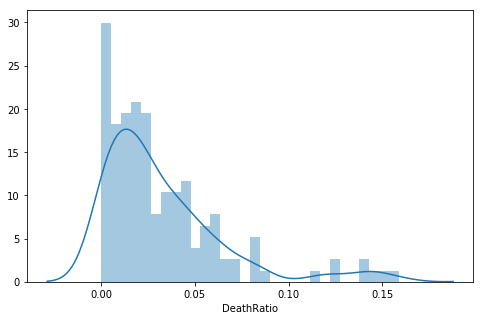

In [17]:
# Look at Death Ratio
plt.figure(figsize=(8,5))
sns.distplot(covid_int3['DeathRatio'], bins=30)
print(covid_int3.DeathRatio.describe())

Mean > Median > Mode --> Distribution for Death Ratio is right skewed, meaning there are a few countries with high death ratios that are skewing the data.

count    145.000000
mean       0.632166
std        0.258965
min        0.000000
25%        0.436000
50%        0.655000
75%        0.865000
max        1.000000
Name: RecoveredRatio, dtype: float64


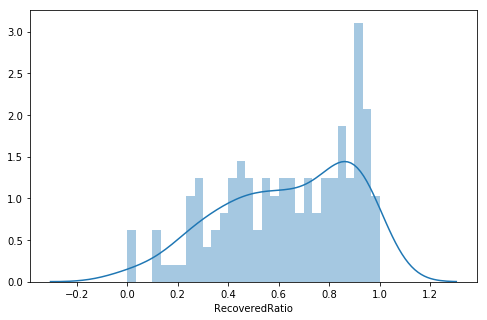

In [18]:
# Look at Recovered Ratio
plt.figure(figsize=(8,5))
sns.distplot(covid_int3['RecoveredRatio'], bins=30)
print(covid_int3.RecoveredRatio.describe())

Mean < Median < Mode --> Distribution for Death Ratio is left skewed, meaning there are a few countries with low recovery ratios that are skewing the data.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f17ec3fab38>,
      dtype=object)

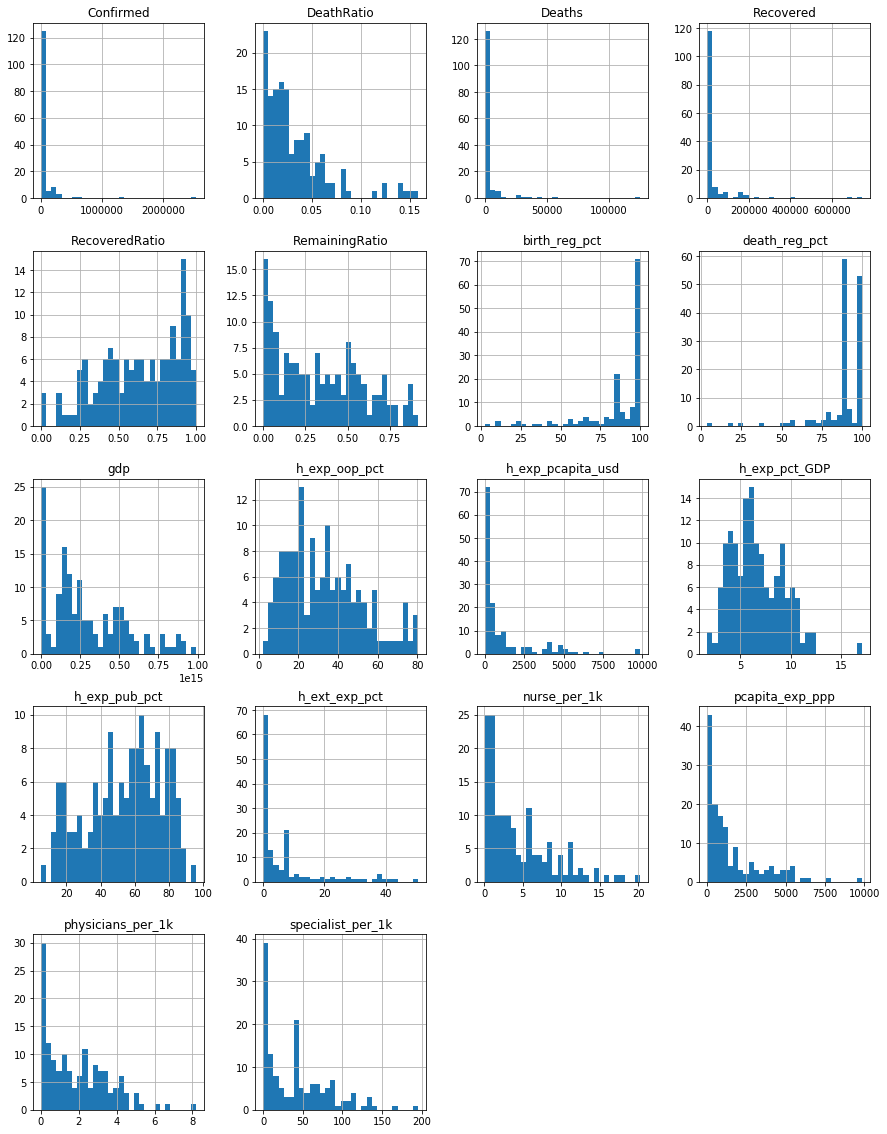

In [19]:
covid_int3.hist(figsize=(15, 20), bins=30, xlabelsize=10, ylabelsize=10)

Observations:
1. More countries with lower death ratio and higher recovery ratio
2. Health Expense per Capita in USD and per Capita PPP is < 2500
3. There is more Public Funding for Health Expenses than External Funding (includes gvt expenses)

In [22]:
# Analysis on Death Ratio and Recovered Ratio for those countries with the highest number of cases
covid_int3.sort_values(['Confirmed','RecoveredRatio'], ascending=[False,False]).head()
# US, Brazil, Russia, India, UK
# Death Ratio: UK highest / Russia Lowest
# Recovered Ratio: Russia highest / US and UK Lowest

# Analysis on Countries with higher health expense percentages and higher external/public funding
covid_int3.sort_values('pcapita_exp_ppp', ascending=False).head() # US, Switzerland, Luxembourg, Norway, Germany
covid_int3.sort_values('h_exp_pcapita_usd', ascending=False).head() # US, Switzerland, Norway, Luxembourg, Sweden
covid_int3.sort_values('h_exp_pct_GDP', ascending=False).head() # US, Cuba, Switzerland, Brazil, France
covid_int3.sort_values('h_exp_oop_pct', ascending=False).head() # Armenia, Azerbaijan, Iraq, Afghanistan, Nigeria
covid_int3.sort_values('h_exp_pub_pct', ascending=False).head() # Seychelles, Cuba, Oman, Norway, Germany
covid_int3.sort_values('h_ext_exp_pct', ascending=False).head() # Rwanda, Zambia, Central African Republic, Uganda, Burundi

,Country/Region,Deaths,Recovered,Confirmed,DeathRatio,RecoveredRatio,RemainingRatio,h_exp_pct_GDP,h_exp_pub_pct,h_exp_oop_pct,h_exp_pcapita_usd,pcapita_exp_ppp,h_ext_exp_pct,physicians_per_1k,nurse_per_1k,specialist_per_1k,birth_reg_pct,death_reg_pct,gdp
115,Rwanda,2.0,443.0,900.0,0.002,0.492,0.506,6.8,33.9,6.4,48.1,130.4,50.6,0.1,0.8,0.8,56.0,89.223,8.007053e+14
143,Zambia,22.0,1311.0,1557.0,0.014,0.842,0.144,4.5,38.3,12.1,56.5,175.2,42.5,0.1,0.9,1.5,11.3,89.223,2.624127e+14
28,Central African Republic,45.0,699.0,3429.0,0.013,0.204,0.783,4.3,14.9,43.1,16.4,29.9,40.9,0.1,0.2,0.4,61.0,89.223,1.385019e+14
135,Uganda,0.0,794.0,859.0,0.000,0.924,0.076,6.2,16.6,40.3,37.6,117.1,40.4,0.1,0.6,1.1,32.2,89.223,2.627705e+14
23,Burundi,1.0,115.0,170.0,0.006,0.676,0.318,6.2,29.1,30.5,18.5,50.3,38.6,0.1,0.7,0.4,83.5,89.223,2.343733e+14


2. Look at Death Ratio Correlation to other variables

In [21]:
def tukey_outliers(df,column,extreme=False):
    q1, q3 = np.percentile(df[column],[25,75])
    iqr = q3 - q1
    constant = 1.5 if not extreme else 3
    return df[~((df[column]>(q3+constant*iqr)) | (df[column]<(q1-constant*iqr)))]

In [36]:
#deaths = tukey_outliers(covid_int3, 'DeathRatio', extreme=True)
deaths = covid_int3.copy()
deaths_corr = deaths.corr()['DeathRatio']
deaths_most_corr = deaths_corr[abs(deaths_corr) > 0.15].sort_values(ascending=False)
deaths_most_corr

DeathRatio           1.000000
h_exp_pct_GDP        0.383950
pcapita_exp_ppp      0.383050
h_exp_pcapita_usd    0.369457
Deaths               0.360318
specialist_per_1k    0.341441
physicians_per_1k    0.323743
nurse_per_1k         0.266217
h_exp_pub_pct        0.244285
birth_reg_pct        0.168605
death_reg_pct        0.167774
h_ext_exp_pct       -0.163249
Name: DeathRatio, dtype: float64

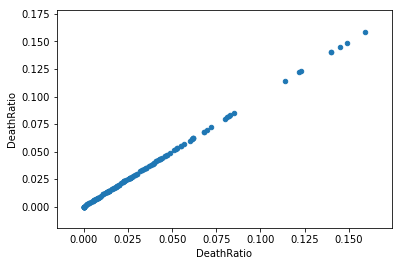

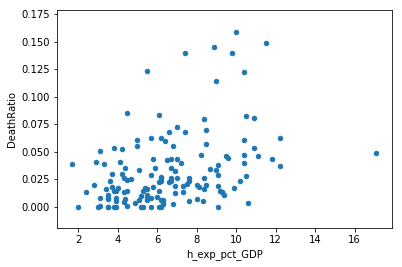

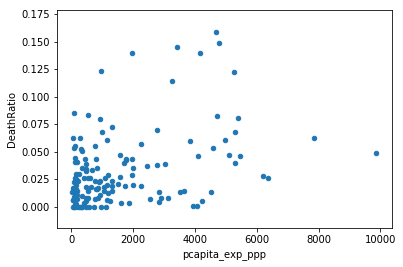

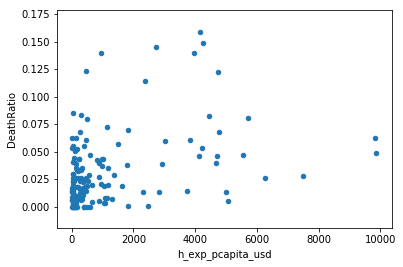

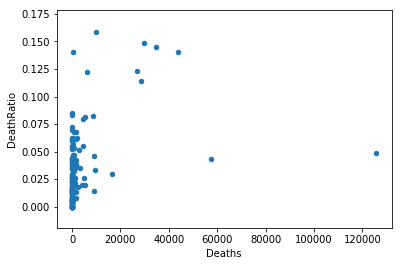

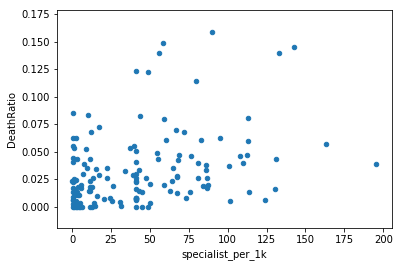

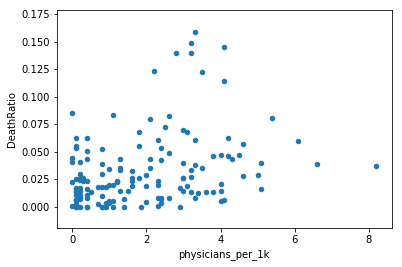

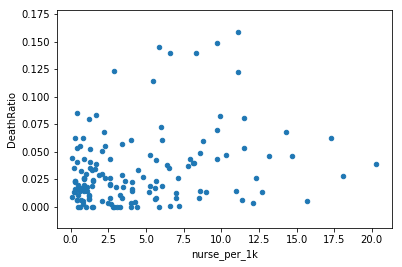

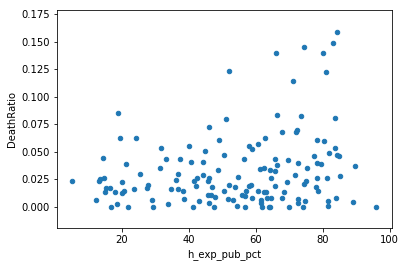

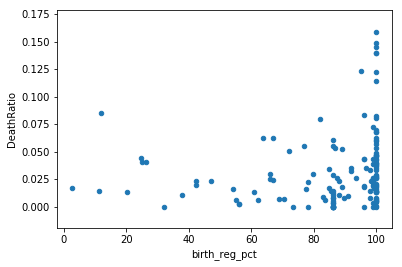

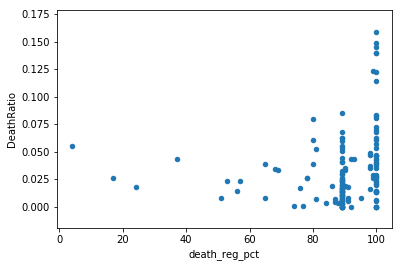

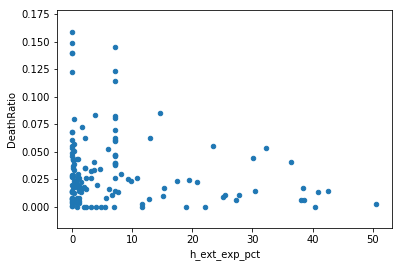

In [37]:
for idx in deaths_most_corr.index:
    deaths.plot(kind='scatter', x=idx, y='DeathRatio')

Excluding outliers made correlation less strong, so we decided to exclude them. Death ratio has positive correlation with Health Expense per Capita in USD and in PPP. Death ratio has a negative correlation with Public and External Funding.

3. Look at Recovery Ratio Correlation to other variables

In [44]:
recov = tukey_outliers(covid_int3, 'RecoveredRatio', extreme=False)
#recov = covid_int3.copy()
recov_corr = recov.corr()['RecoveredRatio']
recov_most_corr = recov_corr[abs(recov_corr) > 0.15].sort_values(ascending=False)
recov_most_corr

RecoveredRatio       1.000000
nurse_per_1k         0.302755
physicians_per_1k    0.294869
birth_reg_pct        0.241745
h_exp_pub_pct        0.216044
pcapita_exp_ppp      0.196082
specialist_per_1k    0.188688
h_exp_pcapita_usd    0.164306
h_ext_exp_pct       -0.161926
Deaths              -0.179066
RemainingRatio      -0.991810
Name: RecoveredRatio, dtype: float64

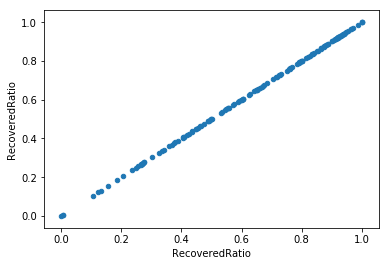

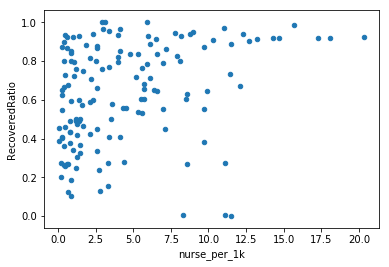

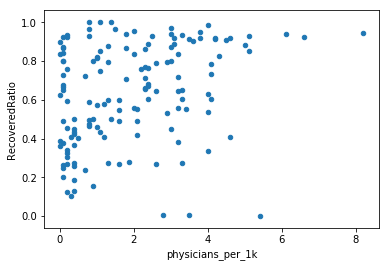

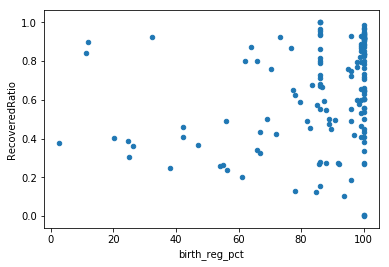

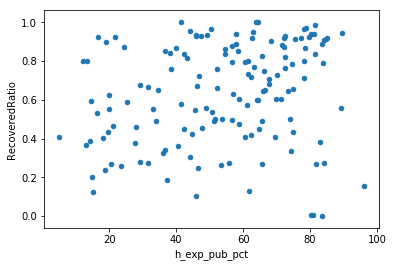

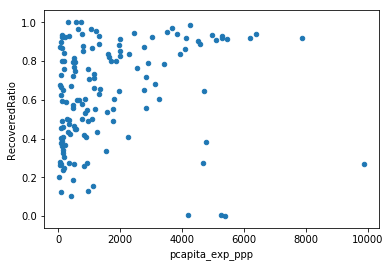

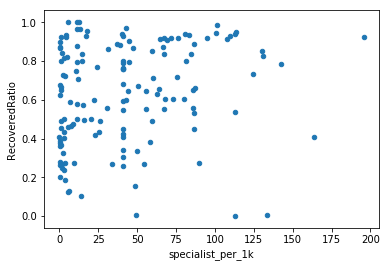

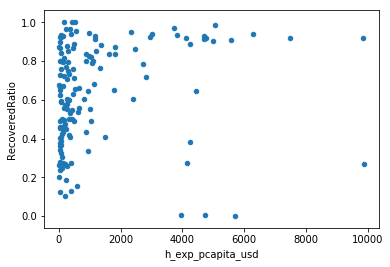

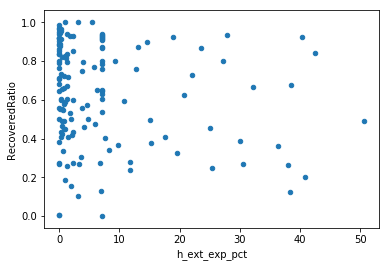

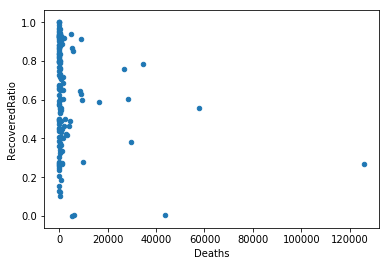

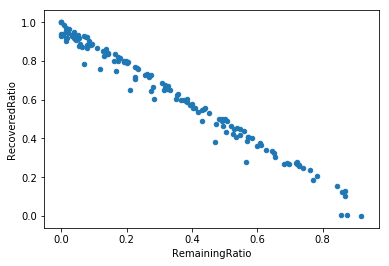

In [43]:
for idx in recov_most_corr.index:
    recov.plot(kind='scatter', x=idx, y='RecoveredRatio')

We decided to exclude outliers using the Tukey Test.

4. Look at distribution for Death and Recovery Ratio

- Death Ratio QQ Plot

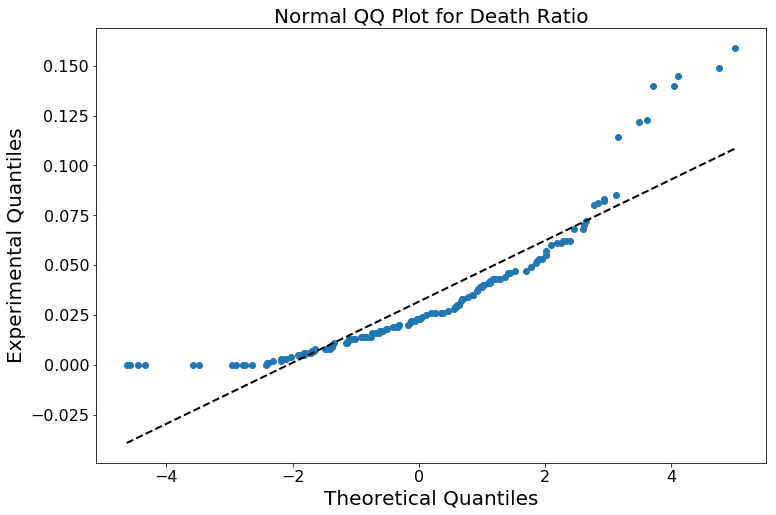

In [51]:
# Plot Dependent Variable
data = covid_int3['DeathRatio'].sort_values()
norm = np.random.normal(0,2,len(data))
norm.sort()
plt.figure(figsize=(12,8), facecolor='1.0')
plt.plot(norm,data,'o')

# Add Line
z = np.polyfit(norm,data,1)
p = np.poly1d(z)
plt.plot(norm,p(norm),"k--",linewidth=2)
plt.title("Normal QQ Plot for Death Ratio", size=20)
plt.xlabel("Theoretical Quantiles", size=20)
plt.ylabel("Experimental Quantiles", size=20)
plt.tick_params(labelsize=16)
plt.show()

Most points fall close to the normality line but curve off in the extremities, which means the data has more extreme values than expected if it came from a Normal Distribution. Overall it is slightly curved as well, meaning the data is skewed.

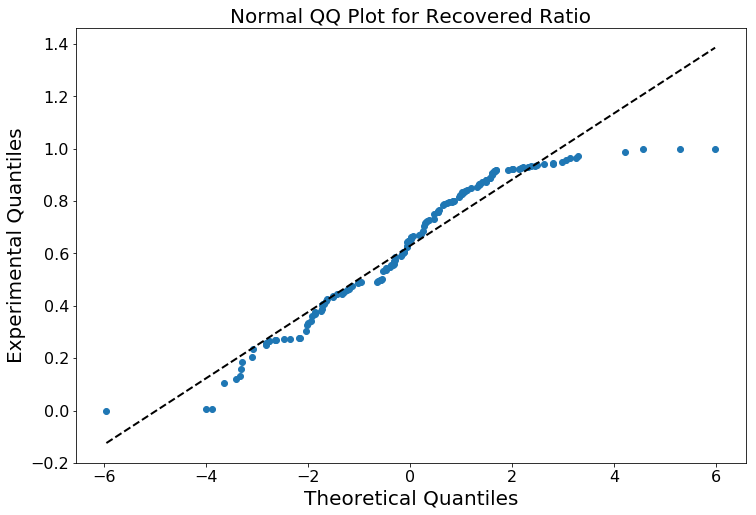

In [56]:
# Plot Dependent Variable
data = covid_int3['RecoveredRatio'].sort_values()
norm = np.random.normal(0,2,len(data))
norm.sort()
plt.figure(figsize=(12,8), facecolor='1.0')
plt.plot(norm,data,'o')

# Add Line
z = np.polyfit(norm,data,1)
p = np.poly1d(z)
plt.plot(norm,p(norm),"k--",linewidth=2)
plt.title("Normal QQ Plot for Recovered Ratio", size=20)
plt.xlabel("Theoretical Quantiles", size=20)
plt.ylabel("Experimental Quantiles", size=20)
plt.tick_params(labelsize=16)
plt.show()

Most of the data points fall close to the normality line, but a few points curve off on the higher tail. It looks like the data is skewed and that there are a few extreme values within the higher experimental quantiles.

5. Regression

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
X = covid_health.drop(columns = ['Deaths','DeathRatio'])
y= covid_health['DeathRatio']
from sklearn.model_selection import train_test_split
X_train, X_test, trainy_u, testy_u = train_test_split(X, y, test_size=0.5, random_state=2)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
sta_X = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
sta_X_t = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

model = LinearRegression().fit(X_train, trainy_u)
r_sq = model.score(X_train, trainy_u)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)